### Model Evaluation

Here we evaluate the four models using the test images



In [1]:
# organize imports
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.preprocessing import image
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import numpy as np
import h5py
import os
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import glob
import seaborn as sns
from PIL import Image

Using TensorFlow backend.
C:\deeplearning\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# load the user configs
with open('room_recognition/conf/conf_eval.json') as f:    
  config = json.load(f)

# config variables

seed      = config["seed"]
train_features_path   = config["train_features_path"]
train_labels_path   = config["train_labels_path"]
test_features_path   = config["test_features_path"]
test_labels_path   = config["test_labels_path"]
results_log     = config["results_logistic"]
classifier_path_log = config["classifier_path_logistic"]
model_log=config["model_path_logistic"]
train_path    = config["train_path"]
test_path =config["test_path"]
num_classes   = config["num_classes"]
results_svm     = config["results_svm"]
classifier_path_svm = config["classifier_path_svm"]
model_svm=config["model_path_svm"]
results_xgboost    = config["results_xgboost"]
classifier_path_xgboost = config["classifier_path_xgboost"]
model_xgboost=config["model_path_xgboost"]
results_rf    = config["results_rf"]
classifier_path_rf = config["classifier_path_rf"]
model_rf=config["model_path_rf"]

In [3]:
#Import test features
h5f_data_test  = h5py.File(test_features_path, 'r')
h5f_label_test = h5py.File(test_labels_path, 'r')

test_features_string = h5f_data_test['dataset_1']
test_labels_string   = h5f_label_test['dataset_1']

testfeatures = np.array(test_features_string)
testlabels   = np.array(test_labels_string)

h5f_data_test.close()
h5f_label_test.close()

In [4]:
# verify the shape of features and labels
print ("[INFO] features shape: {}".format(testfeatures.shape))
print ("[INFO] labels shape: {}".format(testlabels.shape))

[INFO] features shape: (160, 2048)
[INFO] labels shape: (160,)


In [5]:
def print_report( clf_name, y, y_pred):
    ## This function  takes a model name(clf_name), y labels(y), predicted y labels(y_pred) and predicted probabilities(y_score)
    ## It calculates  precision, recall and F1 score, confusion matrix 
    ## It returns a report with the metrics and the confusion matrix
    
    clf_rep = metrics.precision_recall_fscore_support(y, y_pred)
 
    accuracy=metrics.accuracy_score(y, y_pred)
    
    out_dict = {     
                    "precision_score" :clf_rep[0].round(2),
                     "recall_score" : clf_rep[1].round(2),
                     "f1_score" : clf_rep[2].round(2),
                      "support" : clf_rep[3]
                     
        
                }
    out_df = pd.DataFrame(out_dict)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    
    out_df = out_df.append(avg_tot)

    cols = [ 'precision_score', 'recall_score','f1_score', "support"]
    models_report = pd.DataFrame(columns=cols)
   
   
    models_report = models_report.append(out_df)
    models_report["model"]= clf_name
    models_report["accuracy"]=round(accuracy, 3)
    
    conf_matrix=dict()
    
    conf_matrix = pd.crosstab(y, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        

    
    return models_report, conf_matrix

In [6]:
def run_models(clfs_dict, test_X, test_y):
    ## This function takes a dictionary clfs_dict with classifier name and classsifier as keys and values, and X and y
    ## It fits the classifier
    ## returns predicted y and predicted probabilities for y 

    clfs = clfs_dict
    
    cols = ['model', 'accuracy', 'precision_score', 'recall_score','f1_score', "support"]
    
    Full_report = pd.DataFrame(columns = cols)
   
    conf_matrix_all = dict()
    Full_report_dict=dict()
    all_wrong_pred=dict()
    all_right_pred=dict()
    

    for clf, clf_name in zip(clfs.values(), clfs.keys()):
        
        test_y_pred=clf.predict(test_X)
        
        index = 1
        wrong_pred = []
        right_pred =[]
        for true, predict in zip(test_y, test_y_pred):
            
            if true != predict:                          #store mislabelled predictions for viewing in wrong_pred
            
              wrong_pred.append((index, true, predict))
            else:
              right_pred.append((index, true, predict))  #store correctly labelled predictions in right _pred
               
            index +=1
         
        report, conf_matrix = print_report(clf_name, test_y, test_y_pred)
    
        Full_report = Full_report.append(report, ignore_index = False, sort=False)
         
        all_wrong_pred[clf_name] =wrong_pred
        all_right_pred[clf_name] =right_pred
         
        conf_matrix_all[clf_name] =conf_matrix
    
    return Full_report,  conf_matrix_all, all_wrong_pred, all_right_pred
    

In [7]:
clfs ={'LogisticRegression' : joblib.load(model_log),
      
       'RandomForestClassifier': joblib.load(model_rf),
       
        "Support Vector" : joblib.load(model_svm) 
          
  }
    

Full_report,  conf_matrix_all , all_wrong_pred, all_right_pred= run_models(clfs, testfeatures, testlabels)

In [8]:
testlabels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7], dtype=int64)

###### Load XGBOOST Model

In [9]:
bst = xgb.Booster()
bst.load_model(model_xgboost)

In [10]:
dtest = xgb.DMatrix(testfeatures)
ypred = bst.predict(dtest)



In [11]:
#store wrongly predicted and correctly predicted images using xgboost in all_wrong_pred and all_right_pred

index = 1
right_name=[]
wrong_name = []
for true, predict in zip(testlabels, ypred):
        if true != predict: 
              wrong_name.append((index, true, predict))
        else:
              right_name.append((index, true, predict))
        index +=1
all_wrong_pred["xgboost"] =wrong_name
all_right_pred['xgboost'] =right_name

In [12]:
report, conf_matrix = print_report("xgboost", testlabels, ypred)

###### GET EVALUATION METRICS FOR ALL 

In [13]:
Full_report = Full_report.append(report, ignore_index = False, sort=False)
    
     
conf_matrix_all["xgboost"] =conf_matrix  

In [14]:

Full_report=Full_report.rename(index={0: 'bathroom', 1:'bedroom', 2: 'corridor', 3: 'dining_room', 4: 'kitchen', 5:'living room', 6: 'pantry', 7:"staircase"})
Full_report= Full_report[['model', 'accuracy', 'precision_score', 'recall_score', 'f1_score', 'support']]


In [15]:
Full_report

model  accuracy  precision_score  recall_score  \
bathroom         LogisticRegression     0.881             0.90          0.90   
bedroom          LogisticRegression     0.881             0.83          0.75   
corridor         LogisticRegression     0.881             1.00          1.00   
dining_room      LogisticRegression     0.881             0.82          0.90   
kitchen          LogisticRegression     0.881             0.94          0.75   
living room      LogisticRegression     0.881             0.71          0.75   
pantry           LogisticRegression     0.881             0.91          1.00   
staircase        LogisticRegression     0.881             0.95          1.00   
avg/total        LogisticRegression     0.881             0.88          0.88   
bathroom     RandomForestClassifier     0.875             0.90          0.95   
bedroom      RandomForestClassifier     0.875             0.80          0.80   
corridor     RandomForestClassifier     0.875             0.91          1.00   
dining_room  RandomForestClassifier     0.875             0.73          0.95   
kitchen      RandomForestClassifier     0.875             1.00          0.70   
living room  RandomForestClassifier     0.875             0.81          0.65   
pantry       RandomForestClassifier     0.875             0.95          1.00   
staircase    RandomForestClassifier     0.875             0.95          0.95   
avg/total    RandomForestClassifier     0.875             0.88          0.88   
bathroom             Support Vector     0.875             0.89          0.85   
bedroom              Support Vector     0.875             0.82          0.90   
corridor             Support Vector     0.875             1.00          0.95   
dining_room          Support Vector     0.875             0.75          0.90   
kitchen              Support Vector     0.875             1.00          0.65   
living room          Support Vector     0.875             0.75          0.75   
pantry               Support Vector     0.875             0.91          1.00   
staircase            Support Vector     0.875             0.95          1.00   
avg/total            Support Vector     0.875             0.88          0.88   
bathroom                    xgboost     0.875             0.85          0.85   
bedroom                     xgboost     0.875             0.76          0.80   
corridor                    xgboost     0.875             0.95          1.00   
dining_room                 xgboost     0.875             0.82          0.90   
kitchen                     xgboost     0.875             1.00          0.70   
living room                 xgboost     0.875             0.84          0.80   
pantry                      xgboost     0.875             0.95          1.00   
staircase                   xgboost     0.875             0.86          0.95   
avg/total                   xgboost     0.875             0.88          0.88   

             f1_score  support  
bathroom         0.90     20.0  
bedroom          0.79     20.0  
corridor         1.00     20.0  
dining_room      0.86     20.0  
kitchen          0.83     20.0  
living room      0.73     20.0  
pantry           0.95     20.0  
staircase        0.98     20.0  
avg/total        0.88    160.0  
bathroom         0.93     20.0  
bedroom          0.80     20.0  
corridor         0.95     20.0  
dining_room      0.83     20.0  
kitchen          0.82     20.0  
living room      0.72     20.0  
pantry           0.98     20.0  
staircase        0.95     20.0  
avg/total        0.87    160.0  
bathroom         0.87     20.0  
bedroom          0.86     20.0  
corridor         0.97     20.0  
dining_room      0.82     20.0  
kitchen          0.79     20.0  
living room      0.75     20.0  
pantry           0.95     20.0  
staircase        0.98     20.0  
avg/total        0.87    160.0  
bathroom         0.85     20.0  
bedroom          0.78     20.0  
corridor         0.98     20.0  
dining_room      0.86     20.0  
kitchen      

Text(0,0.5,'accuracy')

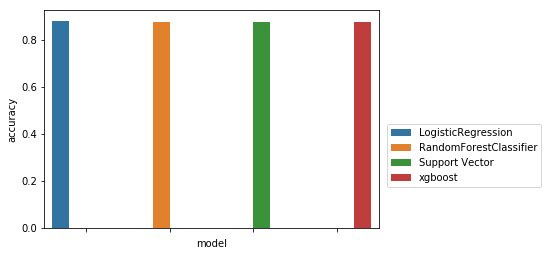

In [16]:
df=Full_report[Full_report.index=="avg/total"]

ax=sns.barplot( x="model", y='accuracy',  hue= 'model', data=df)
plt.xticks()
ax.xaxis.set_major_formatter(plt.NullFormatter()) #hide  x axis labels
ax.legend(bbox_to_anchor=(1.5, 0.5))
plt.ylabel('accuracy')

Text(0,0.5,'precision score')

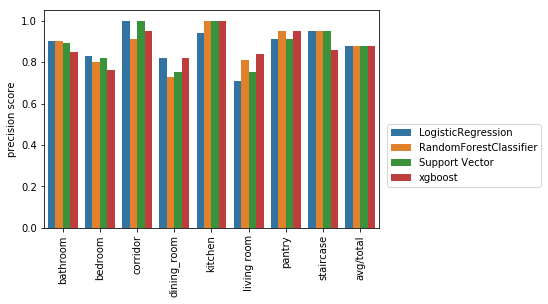

In [17]:

ax=sns.barplot(x=Full_report.index, y='precision_score',  hue= 'model', data=Full_report)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=(1.5, 0.5))
plt.ylabel('precision score')


Text(0,0.5,'recall score')

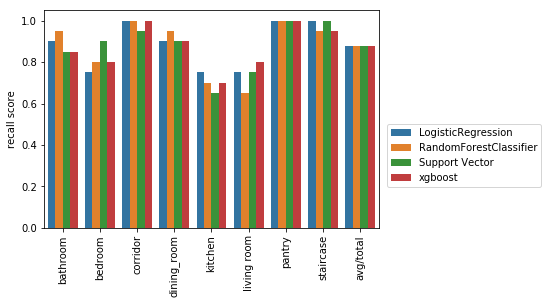

In [18]:
ax=sns.barplot(x=Full_report.index, y='recall_score',  hue= 'model', data=Full_report)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=(1.5, 0.5))
plt.ylabel('recall score')


Text(0,0.5,'f1 score')

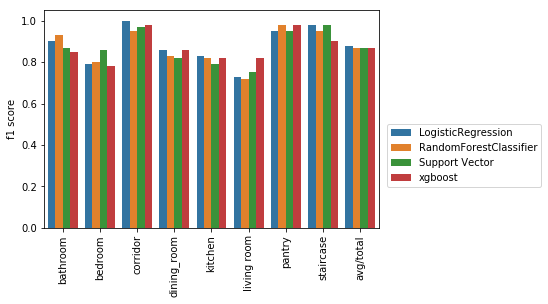

In [19]:
ax=sns.barplot(x=Full_report.index, y='f1_score',  hue= 'model', data=Full_report)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=(1.5, 0.5))
plt.ylabel('f1 score')


In [20]:
conf_matrix_all["LogisticRegression"]

Predicted   0   1   2   3   4   5   6   7
True                                     
0          18   1   0   0   0   0   1   0
1           1  15   0   1   0   3   0   0
2           0   0  20   0   0   0   0   0
3           0   0   0  18   0   1   1   0
4           1   0   0   2  15   2   0   0
5           0   2   0   1   1  15   0   1
6           0   0   0   0   0   0  20   0
7           0   0   0   0   0   0   0  20

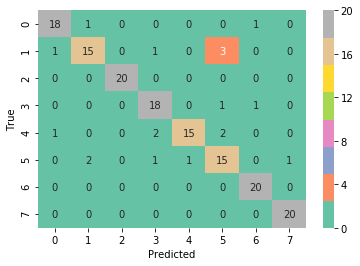

In [21]:
# plot the confusion matrix
cm = conf_matrix_all["LogisticRegression"]
sns.heatmap(cm,
            annot=True,
            cmap="Set2")
plt.show()

In [22]:
test_labels= ['bathroom', 'pantry', 'bedroom', "livingroom" , "dining_room", "corridor", "kitchen", "stairscase"]
labeldict= {0: 'bathroom', 1:'bedroom', 2: 'corridor', 3: 'dining_room', 4: 'kitchen', 5:'living room', 6: 'pantry', 7:"staircase"}


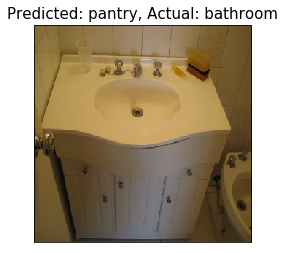

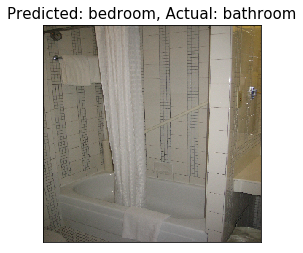

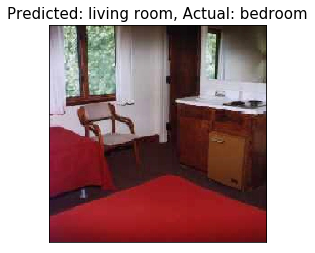

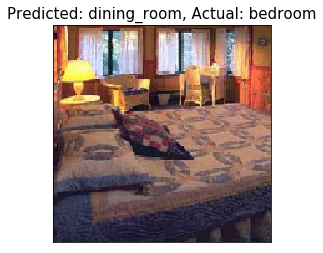

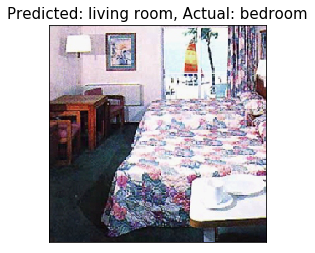

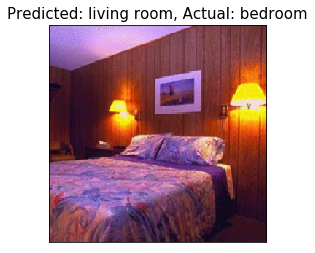

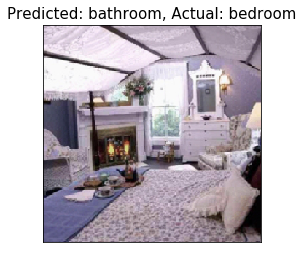

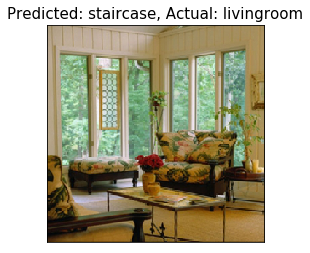

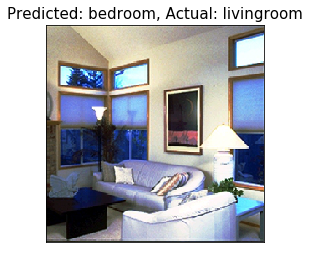

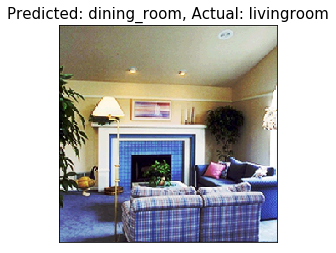

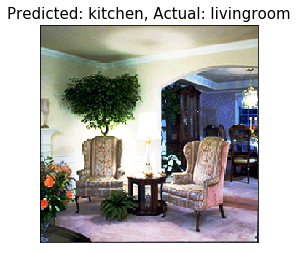

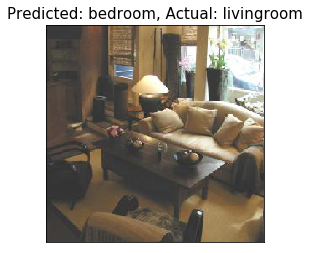

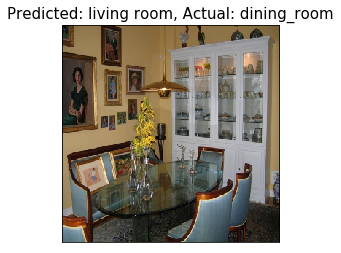

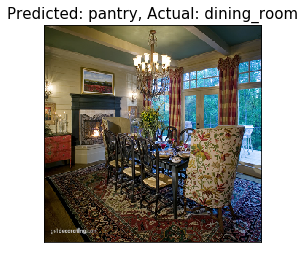

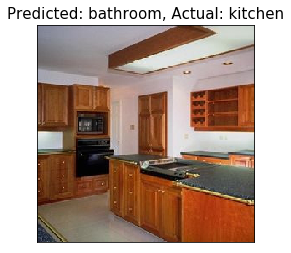

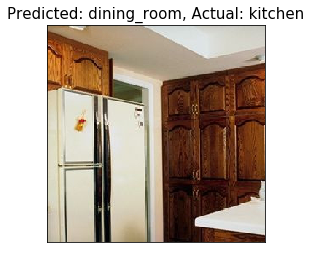

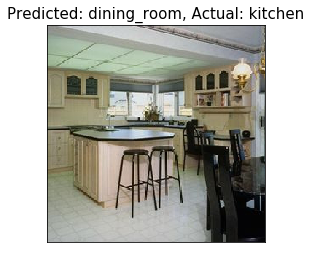

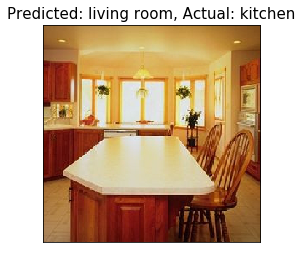

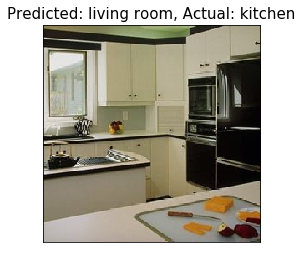

In [23]:


image_size = (299, 299)
# loop over all the labels in the folder
count = 0
for i, label in enumerate(test_labels):
   cur_path = test_path + "/" + label
   for image_path in glob.glob(cur_path + "/*.jpg"):
        count +=1
        for j in all_wrong_pred["LogisticRegression"]:
           if count== j[0]:
             img = image.load_img(image_path, target_size=image_size)
             plt.imshow(img)
             plt.title('Predicted: {}, Actual: {}'.format(labeldict[j[2]], label), fontsize = 15)
             plt.xticks(())
             plt.yticks(())  
             plt.show()
           

In [24]:
conf_matrix_all["RandomForestClassifier"]

Predicted   0   1   2   3   4   5   6   7
True                                     
0          19   1   0   0   0   0   0   0
1           1  16   0   1   0   2   0   0
2           0   0  20   0   0   0   0   0
3           0   0   0  19   0   0   1   0
4           1   0   0   3  14   1   0   1
5           0   3   1   3   0  13   0   0
6           0   0   0   0   0   0  20   0
7           0   0   1   0   0   0   0  19

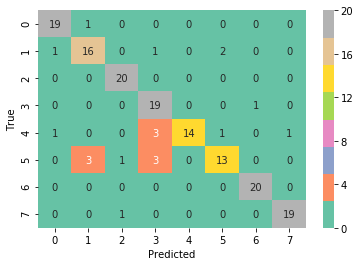

In [25]:
# plot the confusion matrix
cm = conf_matrix_all["RandomForestClassifier"]
sns.heatmap(cm,
            annot=True,
            cmap="Set2")
plt.show()

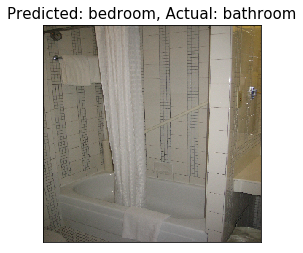

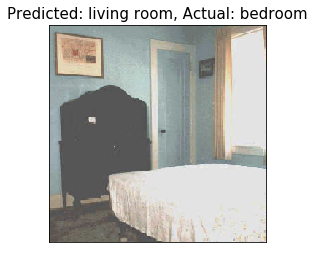

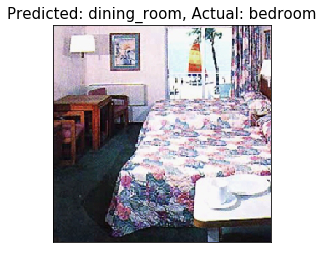

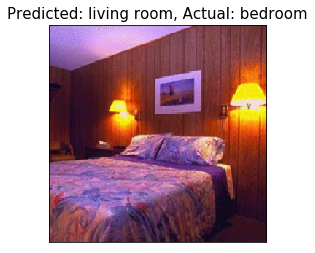

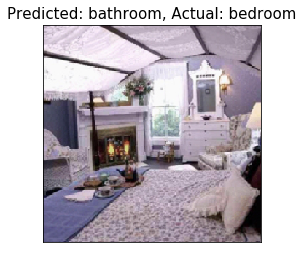

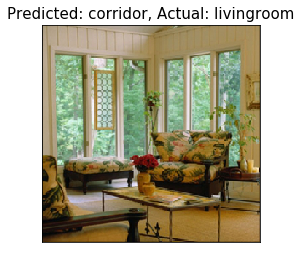

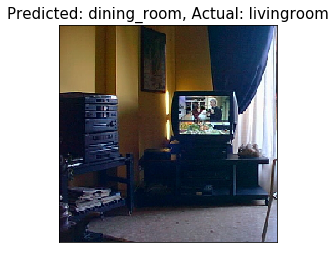

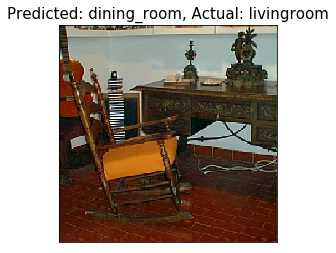

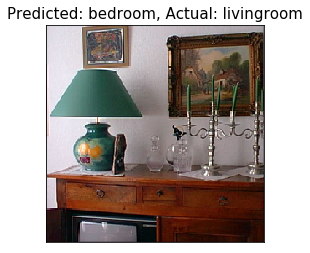

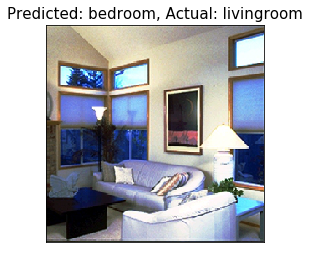

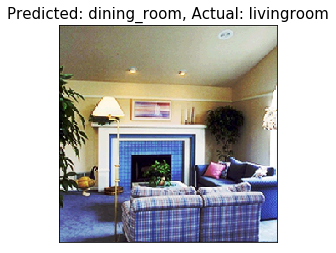

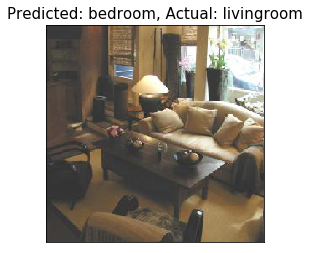

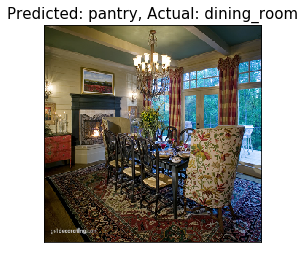

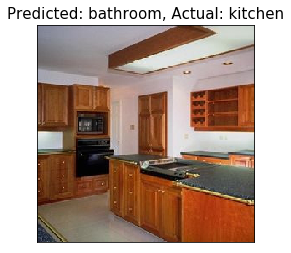

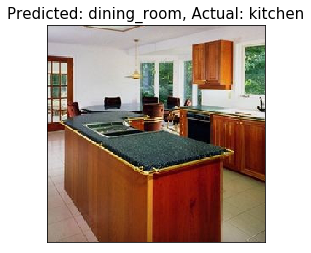

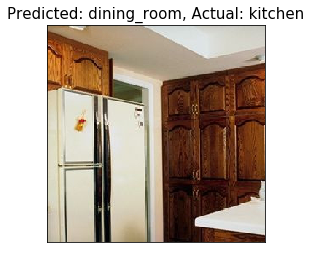

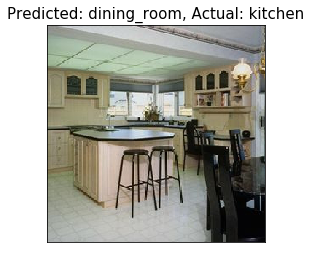

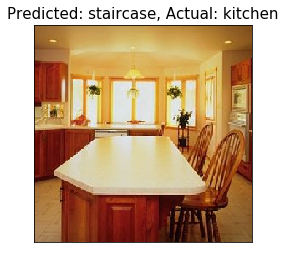

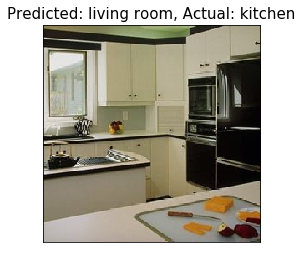

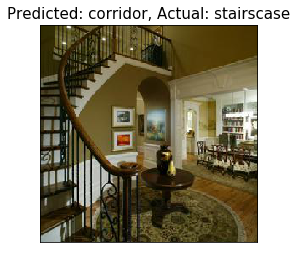

In [26]:
image_size = (299, 299)
# loop over all the labels in the folder
count = 0
for i, label in enumerate(test_labels):
   cur_path = test_path + "/" + label
   for image_path in glob.glob(cur_path + "/*.jpg"):
        count +=1
        for j in all_wrong_pred["RandomForestClassifier"]:
           if count== j[0]:
             img = image.load_img(image_path, target_size=image_size)
             plt.imshow(img)
             plt.title('Predicted: {}, Actual: {}'.format(labeldict[j[2]], label), fontsize = 15)
             plt.xticks(())
             plt.yticks(())  
             plt.show()

In [27]:
conf_matrix_all["Support Vector"]

Predicted   0   1   2   3   4   5   6   7
True                                     
0          17   2   0   0   0   0   1   0
1           1  18   0   0   0   1   0   0
2           0   0  19   1   0   0   0   0
3           0   0   0  18   0   1   1   0
4           1   0   0   3  13   3   0   0
5           0   2   0   2   0  15   0   1
6           0   0   0   0   0   0  20   0
7           0   0   0   0   0   0   0  20

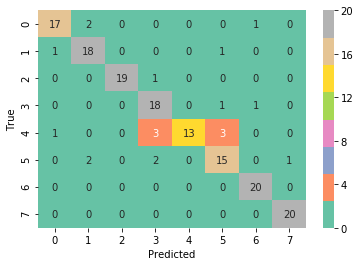

In [28]:
# plot the confusion matrix
cm = conf_matrix_all["Support Vector"]
sns.heatmap(cm,
            annot=True,
            cmap="Set2")
plt.show()

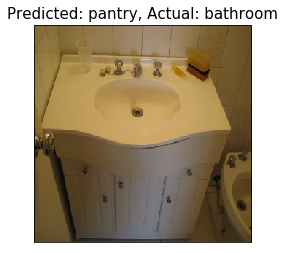

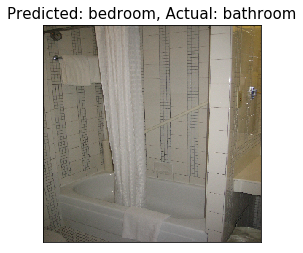

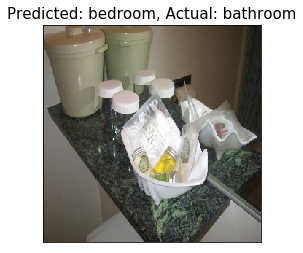

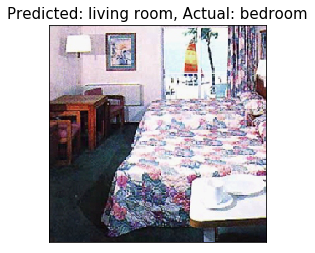

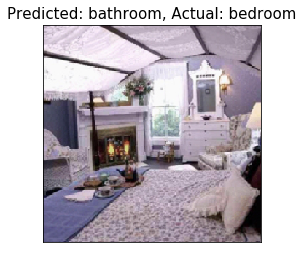

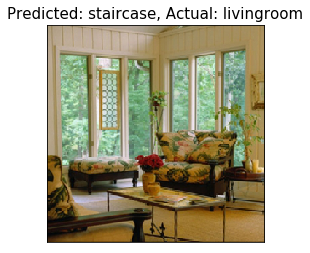

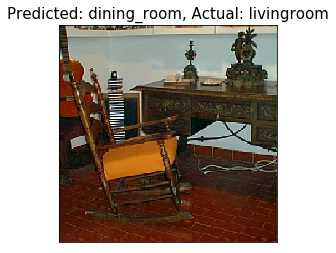

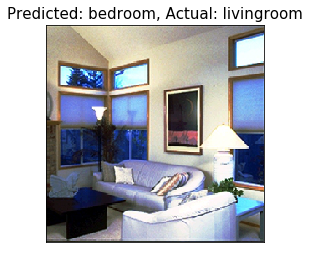

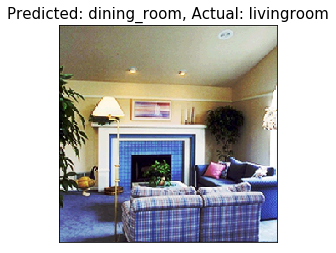

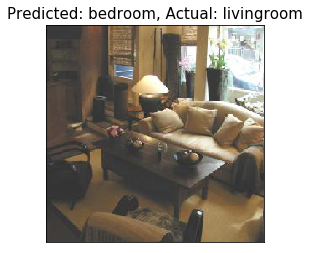

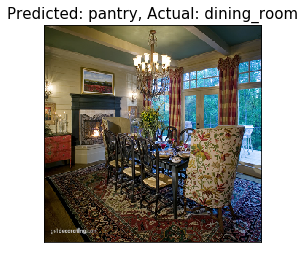

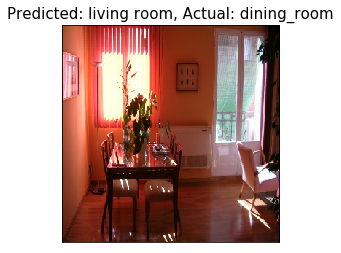

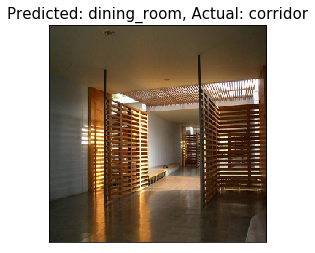

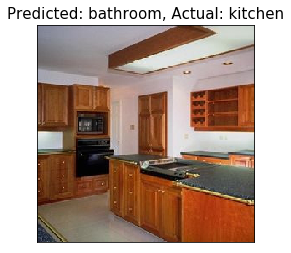

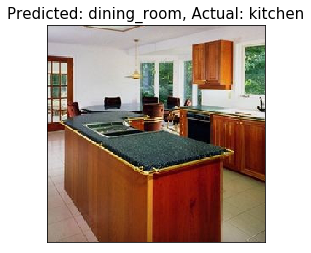

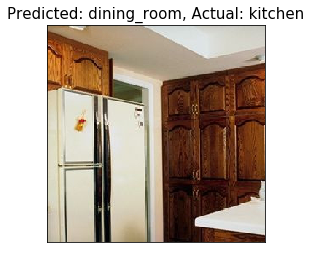

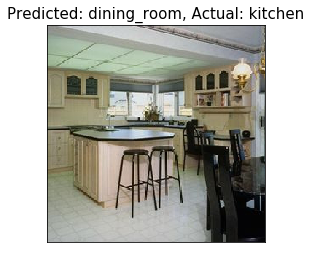

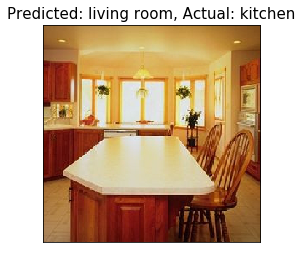

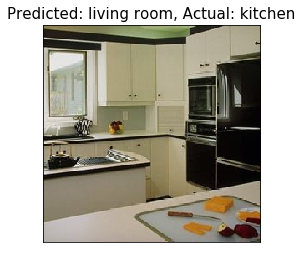

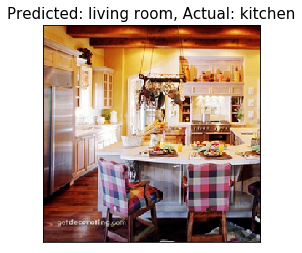

In [29]:
image_size = (299, 299)
# loop over all the labels in the folder
count = 0
for i, label in enumerate(test_labels):
   cur_path = test_path + "/" + label
   for image_path in glob.glob(cur_path + "/*.jpg"):
        count +=1
        for j in all_wrong_pred["Support Vector"]:
           if count== j[0]:
             img = image.load_img(image_path, target_size=image_size)
             plt.imshow(img)
             plt.title('Predicted: {}, Actual: {}'.format(labeldict[j[2]], label), fontsize = 15)
             plt.xticks(())
             plt.yticks(())
             plt.show()

In [30]:
conf_matrix_all["xgboost"]

Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0
True                                             
0           17    2    0    0    0    0    0    1
1            1   16    0    1    0    2    0    0
2            0    0   20    0    0    0    0    0
3            0    0    0   18    0    1    1    0
4            2    0    0    2   14    0    0    2
5            0    3    0    1    0   16    0    0
6            0    0    0    0    0    0   20    0
7            0    0    1    0    0    0    0   19

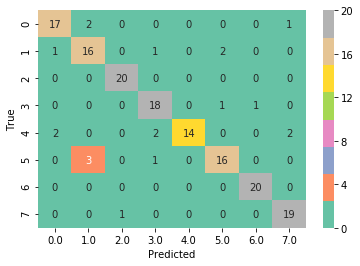

In [31]:
# plot the confusion matrix
cm = conf_matrix_all["xgboost"]
sns.heatmap(cm,
            annot=True,
            cmap="Set2")
plt.show()

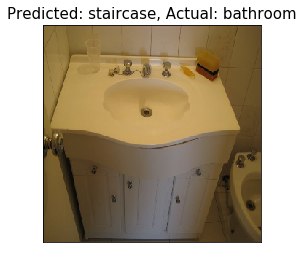

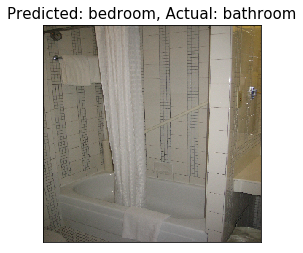

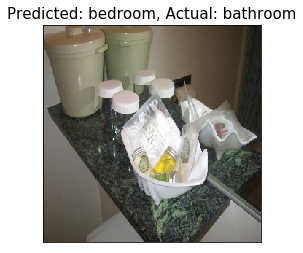

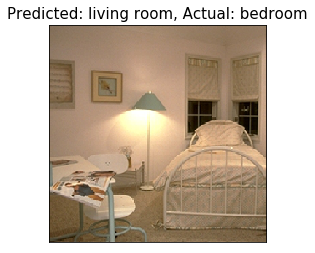

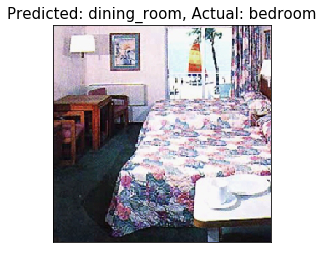

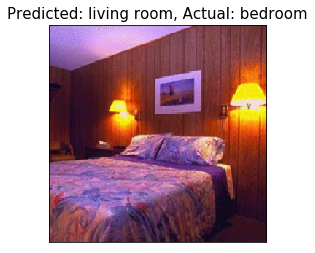

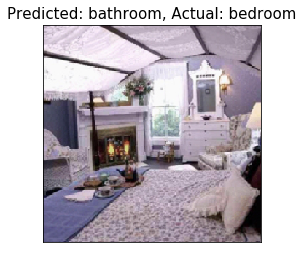

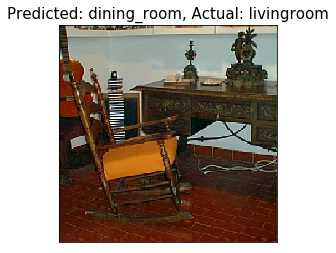

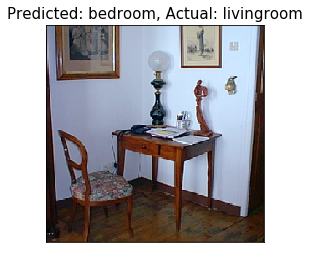

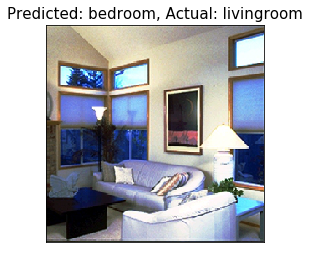

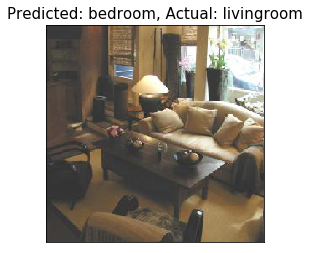

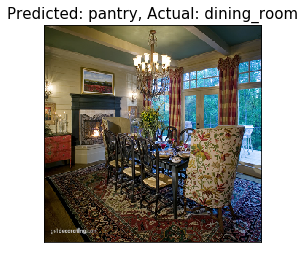

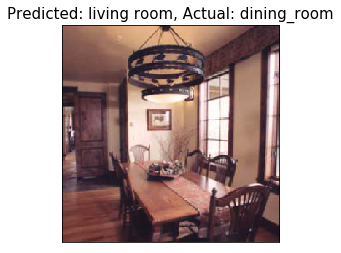

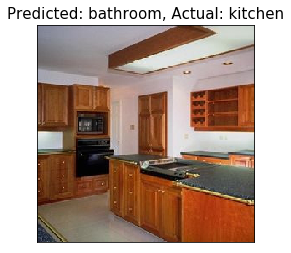

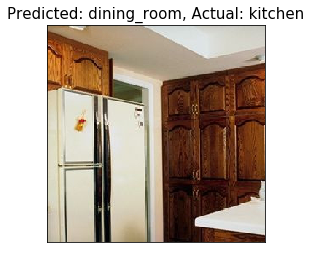

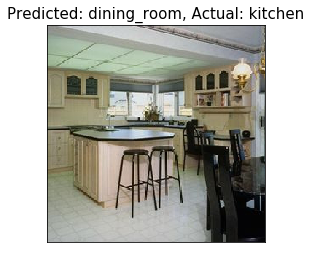

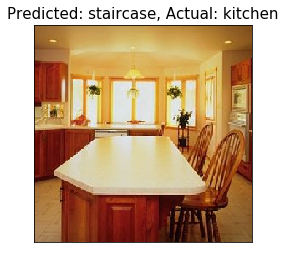

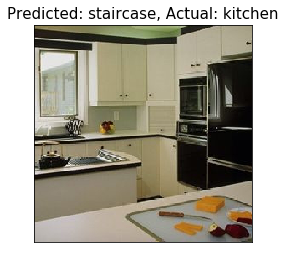

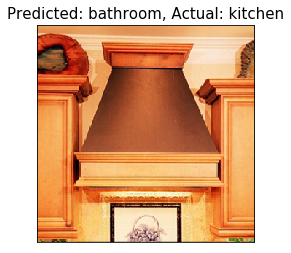

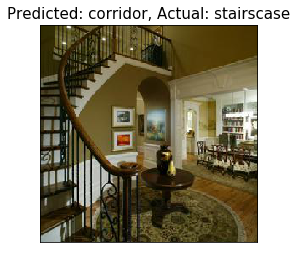

In [32]:
image_size = (299, 299)

# loop over all the labels in the folder
count = 0
for i, label in enumerate(test_labels):
   cur_path = test_path + "/" + label
   for image_path in glob.glob(cur_path + "/*.jpg"):
        count +=1
        for j in all_wrong_pred['xgboost']:
           if count== j[0]:
             img = image.load_img(image_path, target_size=image_size)
             plt.imshow(img)
             plt.xticks(())
             plt.yticks(())
             plt.title('Predicted: {}, Actual: {}'.format(labeldict[j[2]], label), fontsize = 15)
             plt.show()


